# Word Trends
In this notebook, we parse existing text within articles to measure the trends of words. 

There are two main classes used: `TRArticles` for raw data prior to reformatting and `Articles` for data conforming to our standard format.

In [1]:
import pandas as pd
from IPython.display import display 
import gc
import matplotlib.pyplot as plt

from tr_preprocessing import *
from articles import *
from utils import *

## Key Parameters
For our experiment, we set the following parameters.  Below includes:
- whether to load existing data or complete the reformatting/pre-processing steps (`load_data`)
- location of key files (`save_dir`, `csv_file`, `stopwords_files`, `reformatted_df_file`, `tokenized_df_file`, `tokenized_df_file`, `trend_score_files`)
- the fields used to compute the trend scores (and the importance weight of each field) (`text_columns`, `column_weights`)
- language to operate data in (`languages`)
- a list of markers indicating non-article entries (i.e., internal calls) within the dataset (`headline_internal_calls`, `product_internal_calls`)
- reformatting parameters to transform the dataset from `TRArticles` to `Articles` (`drop_cols`, `reformat_dict`)

In [2]:
# Key parameters
load_data = False
verbose = True

csv_file = './rna002_RTRS_2013_06.csv'
stopwords_files = ['./StopWords', './AddStopWords']  # generic stop words and stop words specific to this dataset
save_dir = './data'
reformatted_df_file = 'reformatted_df.csv'
tokenized_df_file = 'tokenized_df.csv'
trend_score_files = ['2013-06-16_2013-06-30_trend_count_score.json', 
                     '2013-06-16_2013-06-30_trend_text_score.json',
                     '2013-06-16_2013-06-30_trend_norm_score.json']
 
text_columns = ['TITLE'] # fields to compute trend scores with
column_weights = [1]
"""
text_columns = ['TITLE', 'TEXT'] # fields to compute trend scores with
column_weights = [5, 1]
"""

languages = ['EN']
headline_internal_calls = ["Test, Please Ignore", "SERVICE ALERT", "THIS IS A TEST MESSAGE"]
product_internal_calls = ["XX", "TEST"]

drop_cols = ['EVENT_TYPE', 'PNAC', 'STORY_DATE_TIME', 'TAKE_DATE_TIME', 'STORY_TYPE', 'HEADLINE_SUBTYPE', 
             'NAMED_ITEMS', 'TABULAR_FLAG', 'ATTRIBUTION', 'RELATED_RICS']

reformat_dict = {'DATE': 'DATE',
                 'TIME': 'TIME',
                 'UNIQUE_STORY_INDEX': 'ID',
                 'HEADLINE_ALERT_TEXT': 'TITLE',
                 'ACCUMULATED_STORY_TEXT': 'TEXT',
                 'TAKE_TEXT': 'TEXT2',
                 'PRODUCTS': 'PLATFORMS',
                 'TOPICS': 'TOPICS',
                 'LANGUAGE': 'LANGUAGE',
                }

# Reformat Data

We load the dataset from its original raw .csv file. This dataset is then used to create an `TRArticles` object, which would be used to reformat the data.

In [3]:
dataset = pd.read_csv(csv_file)

In [4]:
tr_articles = TRArticles(dataset, languages, verbose)

We take the following reformatting steps:
- filter by language
- remove articles with duplicate entries (we aggregate text from `HEADLINE_ALERT_TEXT`, `ACCUMULATED_STORY_TEXT`, and `TAKE_TEXT` across all entries with the same `UNIQUE_STORY_INDEX`)
- remove internal calls which do not correspond to articles
- convert `PRODUCTS` and `TOPICS` to be a set of strings (instead of a long string)
- combine `ACCUMULATED_STORY_TEXT` and `TAKE_TEXT` into a single field (From the dataset, it is unclear how these two fields differ. We assume that they are similar and can be concatenated.)
- rename the fields to correspond to the `Articles` fields and remove unnecessary fields

In [5]:
if load_data:
    tr_articles.load_dataframe(save_dir+'/'+reformatted_df_file)
    reformatted_df = tr_articles.dataframe
else:
    # filter for only English
    tr_articles.filter_language()

    # remove duplicate entries
    tr_articles.remove_duplicate_ids('UNIQUE_STORY_INDEX', ['HEADLINE_ALERT_TEXT','ACCUMULATED_STORY_TEXT', 'TAKE_TEXT'])

    # remove internal calls irrelevant to articles (e.g., test, system alerts)
    tr_articles.remove_internal_calls('HEADLINE_ALERT_TEXT', headline_internal_calls)
    tr_articles.remove_internal_calls('PRODUCTS', product_internal_calls)

    # reformat the dataframe
    tr_articles.convert_string_to_set(['PRODUCTS', 'TOPICS'])
    tr_articles.concatenate_columns(['ACCUMULATED_STORY_TEXT', 'TAKE_TEXT'], remove=True)
    reformatted_df = tr_articles.reformat_dataframe(reformat_dict, drop_cols, keep=False)

Filtering for the following languages:  ['EN']
185747  rows ( 44.02 %) were removed.
Removing duplicate IDs based on:  UNIQUE_STORY_INDEX
136971  rows ( 57.98 %) were removed.
Removing internal calls for  HEADLINE_ALERT_TEXT .
7030  rows ( 7.08 %) were removed.
Removing internal calls for  PRODUCTS .
895  rows ( 0.97 %) were removed.
Concatenating columns:  ['ACCUMULATED_STORY_TEXT', 'TAKE_TEXT']  to  ACCUMULATED_STORY_TEXT
Reformatting dataframe...


In [6]:
reformatted_df.to_csv(save_dir+'/'+reformatted_df_file)
del tr_articles
del dataset
gc.collect()

20

# Pre-Process Data
Output from `TRArticles.reformat_dataframe()` may be used to create an `Articles` object.  This object allows pre-processing of the data, as well as computes trend scores for the words within the data.

We first load stop words from external files.  These words would be removed and would not be used to compute trend scores.

In [7]:
# Load stop words
stop_words = []
for file in stopwords_files:
    stop_words += get_words_from_file(file)

We create the `Articles` object using the reformatted data obtained from the `TRArticles` object.

In [8]:
articles = Articles(reformatted_df, stop_words=stop_words, verbose=verbose)

We pre-process the data with the following procedure.  Note that the order matters and certain steps (e.g., tokenization) must be completed prior to other steps.
- remove "noise" (e.g., special characters, URLs, HTML characters) within our text fields
- remove punctuations by replacing them with whitespace
- tokenize the text within the text fields
- remove stop words
- add Part-of-Speech markers (to be implemented in future versions)
- lemmatize tokens (to be implemented in future versions)

In [9]:
if load_data:
    articles.load_dataframe(save_dir+'/'+tokenized_df_file)
else:
    articles.remove_noise(text_columns)
    articles.replace_punctuations(text_columns, replacement=" ")
    articles.tokenize(text_columns, lower=True)
    articles.remove_stop_words(text_columns)

Removing \n and \t...
Converting HTML characters to Unicode...
Removing URLs...
Replacing punctuations with whitespace...
Tokenizing...
Removing stop words...


# Compute Trend Scores
Now that the data is pre-processed and tokenized, we may compute the trend scores for each word. `Articles.compute_trends()` compute 3 trend scores for each token: 
- `count` based on total number of occurrence of the token 
- `text` based on total articles with the token occurring
- `norm` based the importance of the token within each article.

A `column_weights` argument may be inputted with `text_columns` to indicate the relative importance of each field to the trend score. The trend score computed would reflect this weighting of importance. `Articles.compute_trends()` also allow observing the trends within a set date range. Future implementations would also include filtering articles based on `PRODUCTS` and `TOPICS`.

After computing the trend scores of each word, we rank the tokens descendingly based on their scores.

In [10]:
if load_data:
    articles.load_trend_scores('count', file=save_dir+'/'+trend_score_files[0], date_prefix=True)
    articles.load_trend_scores('text', file=save_dir+'/'+trend_score_files[1], date_prefix=True)
    articles.load_trend_scores('norm', file=save_dir+'/'+trend_score_files[2], date_prefix=True)
else:
    articles.compute_trend(text_columns, column_weights, date_range=['2013-06-23', '2013-06-30'])
articles.rank_tokens()

Computing trend...
Date range  2013-06-23   2013-06-30


In [11]:
articles.save_dataframe(save_loc=save_dir, name=tokenized_df_file)
articles.save_trend_scores(save_dir, date_prefix=True)

# Results
Now that the trend scores of each word is computed, we may observe the top (or bottom) trending words within the specified date range.

We get the top (or bottom) trending words using `Articles.get_trending_words()`.  Note that a method (`count`, `norm`, or `text`) is specified. 

In [12]:
articles.get_trending_words('count', n=20, top=True)

[('shares', 2597.0),
 ('order', 1928.0),
 ('side', 1902.0),
 ('imbalance', 1896.0),
 ('nyse', 1878.0),
 ('sell', 1257.0),
 ('buy', 1236.0),
 ('pct', 1060.0),
 ('buzz', 909.0),
 ('insider', 888.0),
 ('says', 884.0),
 ('price', 782.0),
 ('rating', 719.0),
 ('target', 680.0),
 ('bank', 654.0),
 ('page', 645.0),
 ('results', 626.0),
 ('stocks', 607.0),
 ('markets', 579.0),
 ('power', 565.0)]

We can now plot the top (or bottom) most trending words, as well as their trend score computed with the specified method.

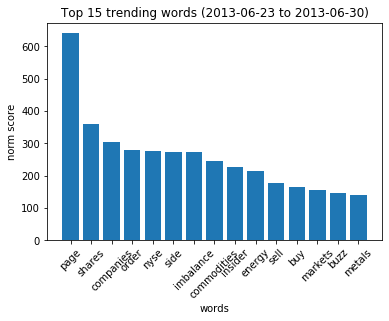

In [13]:
articles.plot_trends('norm', n=15, top=True)